# Sms Spam Ham Prediction

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from textblob import TextBlob
import pandas as pd
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

## Step 1: Load data, look around

In [28]:
df = pd.read_csv('SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE, names=["label", "message"])
print (len(df))
df.head(10)

5574


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


### EDA
##### Exploratory Data Analysis

In [27]:
df.describe()

,label,message
count,5574,5574
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4827,30


In [21]:
df.iloc[1]

label                                ham
message    Ok lar... Joking wif u oni...
Name: 1, dtype: object

In [55]:
m = pd.read_csv('SMSSpamCollection', sep='\t', names = ["label", "message"])
# m.loc[1]
n = [line.rstrip() for line in open('SMSSpamCollection')]
# n[1]
n = pd.read_csv('SMSSpamCollection', sep='\t', names = ["label", "message"])
n.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

C:\Users\WE449GK\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


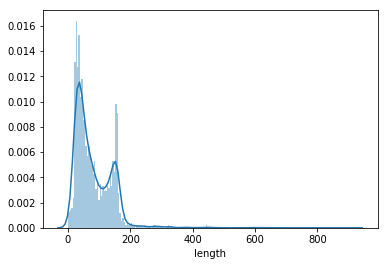

In [88]:
df['length'] = df['message'].apply(len)
import seaborn as sns
sns.distplot(df['length'], bins = 200) 

In [90]:
df['length'].describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

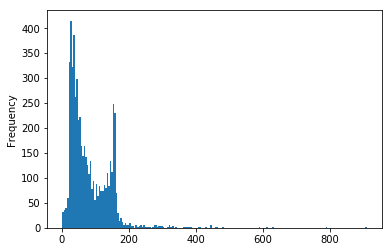

In [86]:
df['length'].plot(bins = 200, kind = 'hist')

In [99]:
df[df['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000154E94DA240>]],
      dtype=object)

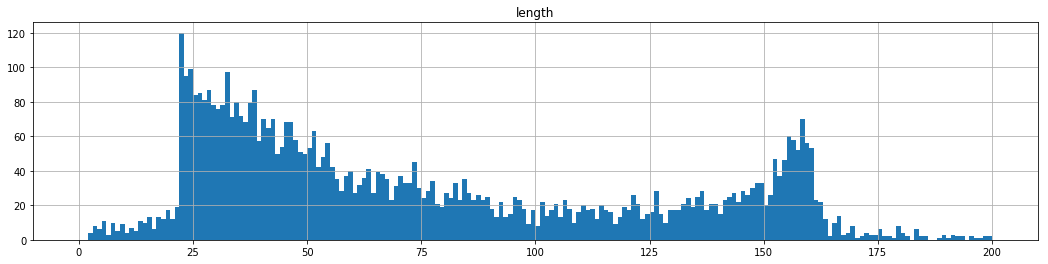

In [110]:
df.hist(column = 'length', bins = 200, figsize = [18,4], range=[0,200])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000154E8F3D198>,
      dtype=object)

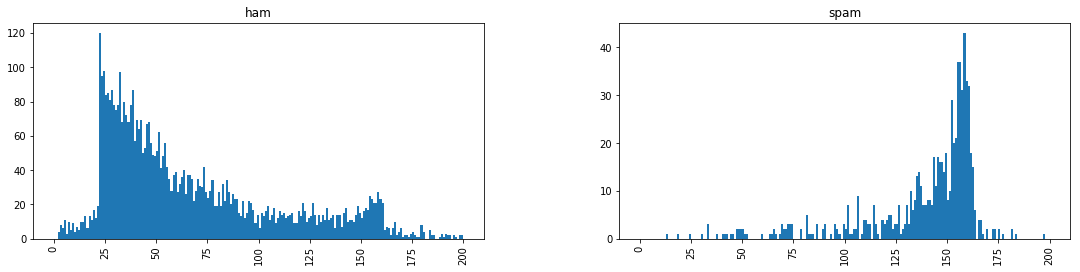

In [109]:
df.hist(column = 'length', by = 'label', bins = 200, figsize = [18,4], range=[0,200])

In [6]:
messages['length'] = messages['message'].map(lambda text: len(text))
print messages.head()

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


In [127]:
df.sort_values(['length'], ascending=False)

,label,message,length
1085,ham,For me the love should start with attraction.i...,910
1863,ham,The last thing i ever wanted to do was hurt yo...,790
2434,ham,Indians r poor but India is not a poor country...,629
1579,ham,How to Make a girl Happy? It's not at all diff...,611
2158,ham,Sad story of a Man - Last week was my b'day. M...,588
2849,ham,Sad story of a Man - Last week was my b'day. M...,588
2380,ham,"Good evening Sir, hope you are having a nice d...",482
3017,ham,"&lt;#&gt; is fast approaching. So, Wish u a v...",461
1513,ham,"Hey sweet, I was wondering when you had a mome...",458
2370,ham,A Boy loved a gal. He propsd bt she didnt mind...,446


In [134]:
df[df['length'] == 22].shape

(120, 3)

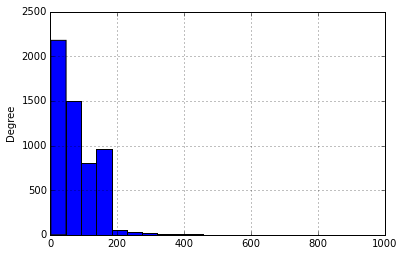

In [7]:
messages.length.plot(bins=20, kind='hist')

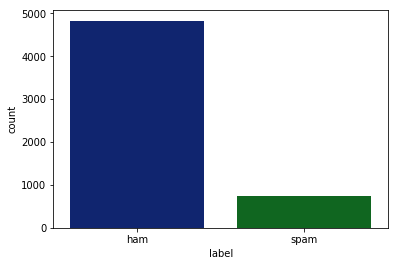

In [139]:
sns.countplot(x = 'label', data = df, palette = 'dark')

In [8]:
messages.length.describe()

count    5574.000000
mean       80.604593
std        59.919970
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

What is that super long message?

In [9]:
print list(messages.message[messages.length > 900])

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


Is there any difference in message length between spam and ham?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1174ade10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11757c9d0>], dtype=object)

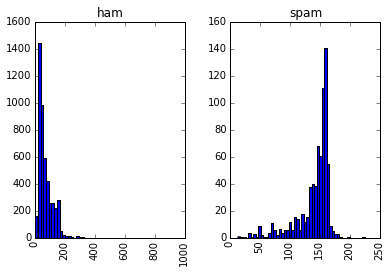

In [10]:
messages.hist(column='length', by='label', bins=50)

Good fun, but how do we make computer understand the plain text messages themselves? Or can it under such malformed gibberish at all?

## Step 2: Data preprocessing

In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

As a first step, let's write a function that will split a message into its individual words:

In [11]:
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

Here are some of the original texts again:
    

In [12]:
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

...and here are the same messages, tokenized:

In [13]:
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

NLP questions:

1. Do capital letters carry information?
2. Does distinguishing inflected form ("goes" vs. "go") carry information?
3. Do interjections, determiners carry information?

In other words, we want to better "normalize" the text.

With textblob, we'd detect [part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) tags with:

In [14]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[(u'Hello', u'UH'),
 (u'world', u'NN'),
 (u'how', u'WRB'),
 (u'is', u'VBZ'),
 (u'it', u'PRP'),
 (u'going', u'VBG')]

and normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation)) with:

In [15]:
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

Better. You can probably think of many more ways to improve the preprocessing: decoding HTML entities (those `&amp;` and `&lt;` we saw above); filtering out stop words (pronouns etc); adding more features, such as an word-in-all-caps indicator and so on.

## Step 3: Data to vectors

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Each vector has as many dimensions as there are unique words in the SMS corpus:

In [16]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print len(bow_transformer.vocabulary_)

8874


Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. It contains a multitude of various methods and options.

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [17]:
message4 = messages['message'][3]
print message4

U dun say so early hor... U c already then say...


In [18]:
bow4 = bow_transformer.transform([message4])
print bow4
print bow4.shape

  (0, 1158)	1
  (0, 1899)	1
  (0, 2897)	1
  (0, 2927)	1
  (0, 4021)	1
  (0, 6736)	2
  (0, 7111)	1
  (0, 7698)	1
  (0, 8013)	2
(1, 8874)


So, nine unique words in message nr. 4, two of them appear twice, the rest only once. Sanity check: what are these words the appear twice?

In [19]:
print bow_transformer.get_feature_names()[6736]
print bow_transformer.get_feature_names()[8013]

say
u


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix:

In [20]:
messages_bow = bow_transformer.transform(messages['message'])
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

sparse matrix shape: (5574, 8874)
number of non-zeros: 80272
sparsity: 0.16%


And finally, after the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`:

In [21]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print tfidf4

  (0, 8013)	0.305114653686
  (0, 7698)	0.225299911221
  (0, 7111)	0.191390347987
  (0, 6736)	0.523371210191
  (0, 4021)	0.456354991921
  (0, 2927)	0.32967579251
  (0, 2897)	0.303693312742
  (0, 1899)	0.24664322833
  (0, 1158)	0.274934159477


What is the IDF (inverse document frequency) of the word `"u"`? Of word `"university"`?

In [22]:
print tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]
print tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

2.85068150539
8.23975323521


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [23]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print messages_tfidf.shape

(5574, 8874)


There are a multitude of ways in which data can be proprocessed and vectorized. These two steps, also called "feature engineering", are typically the most time consuming and "unsexy" parts of building a predictive pipeline, but they are very important and require some experience. The trick is to evaluate constantly: analyze model for the errors it makes, improve data cleaning & preprocessing, brainstorm for new features, evaluate...

## Step 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier. This part is pretty straightforward, and there are many libraries that realize the training algorithms.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [24]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

CPU times: user 3.16 ms, sys: 699 µs, total: 3.86 ms
Wall time: 3.33 ms


Let's try classifying our single random message:

In [25]:
print 'predicted:', spam_detector.predict(tfidf4)[0]
print 'expected:', messages.label[3]

predicted: ham
expected: ham


Hooray! You can try it with your own texts, too.

A natural question is to ask, how many messages do we classify correctly overall?

In [26]:
all_predictions = spam_detector.predict(messages_tfidf)
print all_predictions

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']


In [27]:
print 'accuracy', accuracy_score(messages['label'], all_predictions)
print 'confusion matrix\n', confusion_matrix(messages['label'], all_predictions)
print '(row=expected, col=predicted)'

accuracy 0.969501255831
confusion matrix
[[4827    0]
 [ 170  577]]
(row=expected, col=predicted)


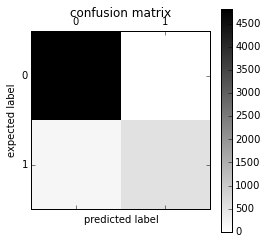

In [28]:
plt.matshow(confusion_matrix(messages['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

From this confusion matrix, we can compute precision and recall, or their combination (harmonic mean) F1:

In [29]:
print classification_report(messages['label'], all_predictions)

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.77      0.87       747

avg / total       0.97      0.97      0.97      5574



There are quite a few possible metrics for evaluating model performance. Which one is the most suitable depends on the task. For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".

## Step 5: How to run experiments?

In the above "evaluation", we committed a cardinal sin. For simplicity of demonstration, we evaluated accuracy on the same data we used for training. **Never evaluate on the same dataset you train on! Bad! Incest!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way -- thanks to this process, we make sure we are not "cheating", and that our final evaluation on test data is representative of true predictive performance.

In [30]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print len(msg_train), len(msg_test), len(msg_train) + len(msg_test)

4459 1115 5574


So, as requested, the test size is 20% of the entire dataset (1115 messages out of total 5574), and the training is the rest (4459 out of 5574).

Let's recap the entire pipeline up to this point, putting the steps explicitly into scikit-learn's `Pipeline`:

In [31]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

A common practice is to partition the training set again, into smaller subsets; for example, 5 equally sized subsets. Then we train the model on four parts, and compute accuracy on the last part (called "validation set"). Repeated five times (taking different part for evaluation each time), we get a sense of model "stability". If the model gives wildly different scores for different subsets, it's a sign something is wrong (bad data, or bad model variance). Go back, analyze errors, re-check input data for garbage, re-check data cleaning.

In our case, everything goes smoothly though:

In [32]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print scores

[ 0.93736018  0.96420582  0.94854586  0.94183445  0.96412556  0.94382022
  0.94606742  0.96404494  0.94831461  0.94606742]


The scores are indeed a little bit worse than when we trained on the entire dataset (5574 training examples, accuracy 0.97). They are fairly stable though:

In [33]:
print scores.mean(), scores.std()

0.9504386476 0.00947200821389


A natural question is, how can we improve this model? The scores are already high here, but how would we go about improving a model in general?

Naive Bayes is an example of a [high bias - low variance](http://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) classifier (aka simple and stable, not prone to overfitting). An example from the opposite side of the spectrum would be Nearest Neighbour (kNN) classifiers, or Decision Trees, with their low bias but high variance (easy to overfit). Bagging (Random Forests) as a way to lower variance, by training many (high-variance) models and averaging.

[![](http://radimrehurek.com/data_science_python/plot_bias_variance_examples_2.png)](http://www.astroml.org/sklearn_tutorial/practical.html#bias-variance-over-fitting-and-under-fitting)

In other words:

* **high bias** = classifer is opinionated. Not as much room to change its mind with data, it has its own ideas. On the other hand, not as much room it can fool itself into overfitting either (picture on the left).
* **low bias** = classifier more obedient, but also more neurotic. Will do exactly what you ask it to do, which, as everybody knows, can be a real nuisance (picture on the right).

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 382 ms, sys: 83.1 ms, total: 465 ms
Wall time: 28.5 s


<module 'matplotlib.pyplot' from '/Volumes/work/workspace/vew/sklearn_intro/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

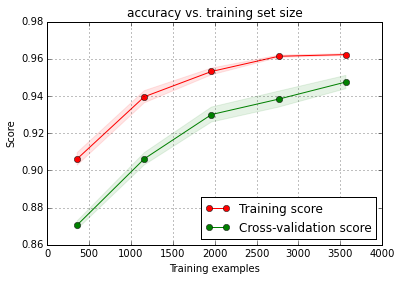

In [35]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5)

(We're effectively training on 64% of all available data: we reserved 20% for the test set above, and the 5-fold cross validation reserves another 20% for validation sets => `0.8*0.8*5574=3567` training examples left.)

Since performance keeps growing, both for training and cross validation scores, we see our model is not complex/flexible enough to capture all nuance, given little data. In this particular case, it's not very pronounced, since the accuracies are high anyway.

At this point, we have two options:

1. use more training data, to overcome low model complexity
2. use a more complex (lower bias) model to start with, to get more out of the existing data

Over the last years, as massive training data collections become more available, and as machines get faster, approach 1. is becoming more and more popular (simpler algorithms, more data). Straightforward algorithms, such as Naive Bayes, also have the added benefit of being easier to interpret (compared to some more complex, black-box models, like neural networks).

Knowing how to evaluate models properly, we can now explore how different parameters affect the performace.

In [ ]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

In [38]:
%time nb_detector = grid.fit(msg_train, label_train)
print nb_detector.grid_scores_

CPU times: user 4.09 s, sys: 291 ms, total: 4.38 s
Wall time: 20.2 s
[mean: 0.94752, std: 0.00357, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_lemmas at 0x1131e8668>}, mean: 0.92958, std: 0.00390, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_lemmas at 0x1131e8668>}, mean: 0.94528, std: 0.00259, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_tokens at 0x11270b7d0>}, mean: 0.92868, std: 0.00240, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_tokens at 0x11270b7d0>}]


(best parameter combinations are displayed first: in this case, `use_idf=True` and `analyzer=split_into_lemmas` take the prize).

A quick sanity check:

In [39]:
print nb_detector.predict_proba(["Hi mom, how are you?"])[0]
print nb_detector.predict_proba(["WINNER! Credit for free!"])[0]

[ 0.99383955  0.00616045]
[ 0.29663109  0.70336891]


The `predict_proba` returns the predicted probability for each class (ham, spam). In the first case, the message is predicted to be ham with > 99% probability, and spam with < 1%. So if forced to choose, the model will say "ham":

In [40]:
print nb_detector.predict(["Hi mom, how are you?"])[0]
print nb_detector.predict(["WINNER! Credit for free!"])[0]

ham
spam


And overall scores on the test set, the one we haven't used at all during training:

In [41]:
predictions = nb_detector.predict(msg_test)
print confusion_matrix(label_test, predictions)
print classification_report(label_test, predictions)

[[973   0]
 [ 46  96]]
             precision    recall  f1-score   support

        ham       0.95      1.00      0.98       973
       spam       1.00      0.68      0.81       142

avg / total       0.96      0.96      0.96      1115



This is then the realistic predictive performance we can expect from our spam detection pipeline, when using lowercase with lemmatization, TF-IDF and Naive Bayes for classifier.

Let's try with another classifier: [Support Vector Machines (SVM)](http://en.wikipedia.org/wiki/Support_vector_machine). SVMs are a great starting point when classifying text data, getting state of the art results very quickly and with pleasantly little tuning (although a bit more than Naive Bayes):

In [42]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

In [43]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm
print svm_detector.grid_scores_

CPU times: user 5.24 s, sys: 170 ms, total: 5.41 s
Wall time: 1min 8s
[mean: 0.98677, std: 0.00259, params: {'classifier__kernel': 'linear', 'classifier__C': 1}, mean: 0.98654, std: 0.00100, params: {'classifier__kernel': 'linear', 'classifier__C': 10}, mean: 0.98654, std: 0.00100, params: {'classifier__kernel': 'linear', 'classifier__C': 100}, mean: 0.98654, std: 0.00100, params: {'classifier__kernel': 'linear', 'classifier__C': 1000}, mean: 0.86432, std: 0.00006, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.86432, std: 0.00006, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.86432, std: 0.00006, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.86432, std: 0.00006, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.97040, std: 0.00587, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rb

So apparently, linear kernel with `C=1` is the best parameter combination.

Sanity check again:

In [44]:
print svm_detector.predict(["Hi mom, how are you?"])[0]
print svm_detector.predict(["WINNER! Credit for free!"])[0]

ham
spam


In [45]:
print confusion_matrix(label_test, svm_detector.predict(msg_test))
print classification_report(label_test, svm_detector.predict(msg_test))

[[965   8]
 [ 13 129]]
             precision    recall  f1-score   support

        ham       0.99      0.99      0.99       973
       spam       0.94      0.91      0.92       142

avg / total       0.98      0.98      0.98      1115



This is then the realistic predictive performance we can expect from our spam detection pipeline, when using SVMs.

## Step 7: Productionalizing a predictor

With basic analysis and tuning done, the real work (engineering) begins.

The final step for a production predictor would be training it on the entire dataset again, to make full use of all the data available. We'd use the best parameters found via cross validation above, of course. This is very similar to what we did in the beginning, but this time having insight into its behaviour and stability. Evaluation was done honestly, on distinct train/test subset splits.

The final predictor can be serialized to disk, so that the next time we want to use it, we can skip all training and use the trained model directly:

In [46]:
# store the spam detector to disk after training
with open('sms_spam_detector.pkl', 'wb') as fout:
    cPickle.dump(svm_detector, fout)

# ...and load it back, whenever needed, possibly on a different machine
svm_detector_reloaded = cPickle.load(open('sms_spam_detector.pkl'))

The loaded result is an object that behaves identically to the original:

In [47]:
print 'before:', svm_detector.predict([message4])[0]
print 'after:', svm_detector_reloaded.predict([message4])[0]

before: ham
after: ham
